In [ ]:
%load_ext autoreload

%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch_receptive_field import receptive_field

from data import PascalVOC2007
from models import vgg11_PascalVOC
from utils import (
    _DeepLiftShap,
    cut_model_to_layer,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [3]:
test_data = PascalVOC2007("test", transform=preprocess)
train_data = PascalVOC2007("trainval", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [4]:
import torch.utils
from torch.utils.data import Subset

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 8

dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=True)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [224, 224]        0.5        1.0             3.0 
        2             [224, 224]        0.5        1.0             3.0 
        3             [112, 112]        1.0        2.0             4.0 
        4             [112, 112]        1.0        2.0             8.0 
        5             [112, 112]        1.0        2.0             8.0 
        6               [56, 56]        2.0        4.0            10.0 
        7               [56, 56]        2.0        4.0            18.0 
        8               [56, 56]        2.0        4.0            18.0 
        9               [56, 56]        2.0        4.0            26.0 
        10              [56, 56]        2.0        4.0            26.0 
        11              [28, 28]        4.0        8.0   

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


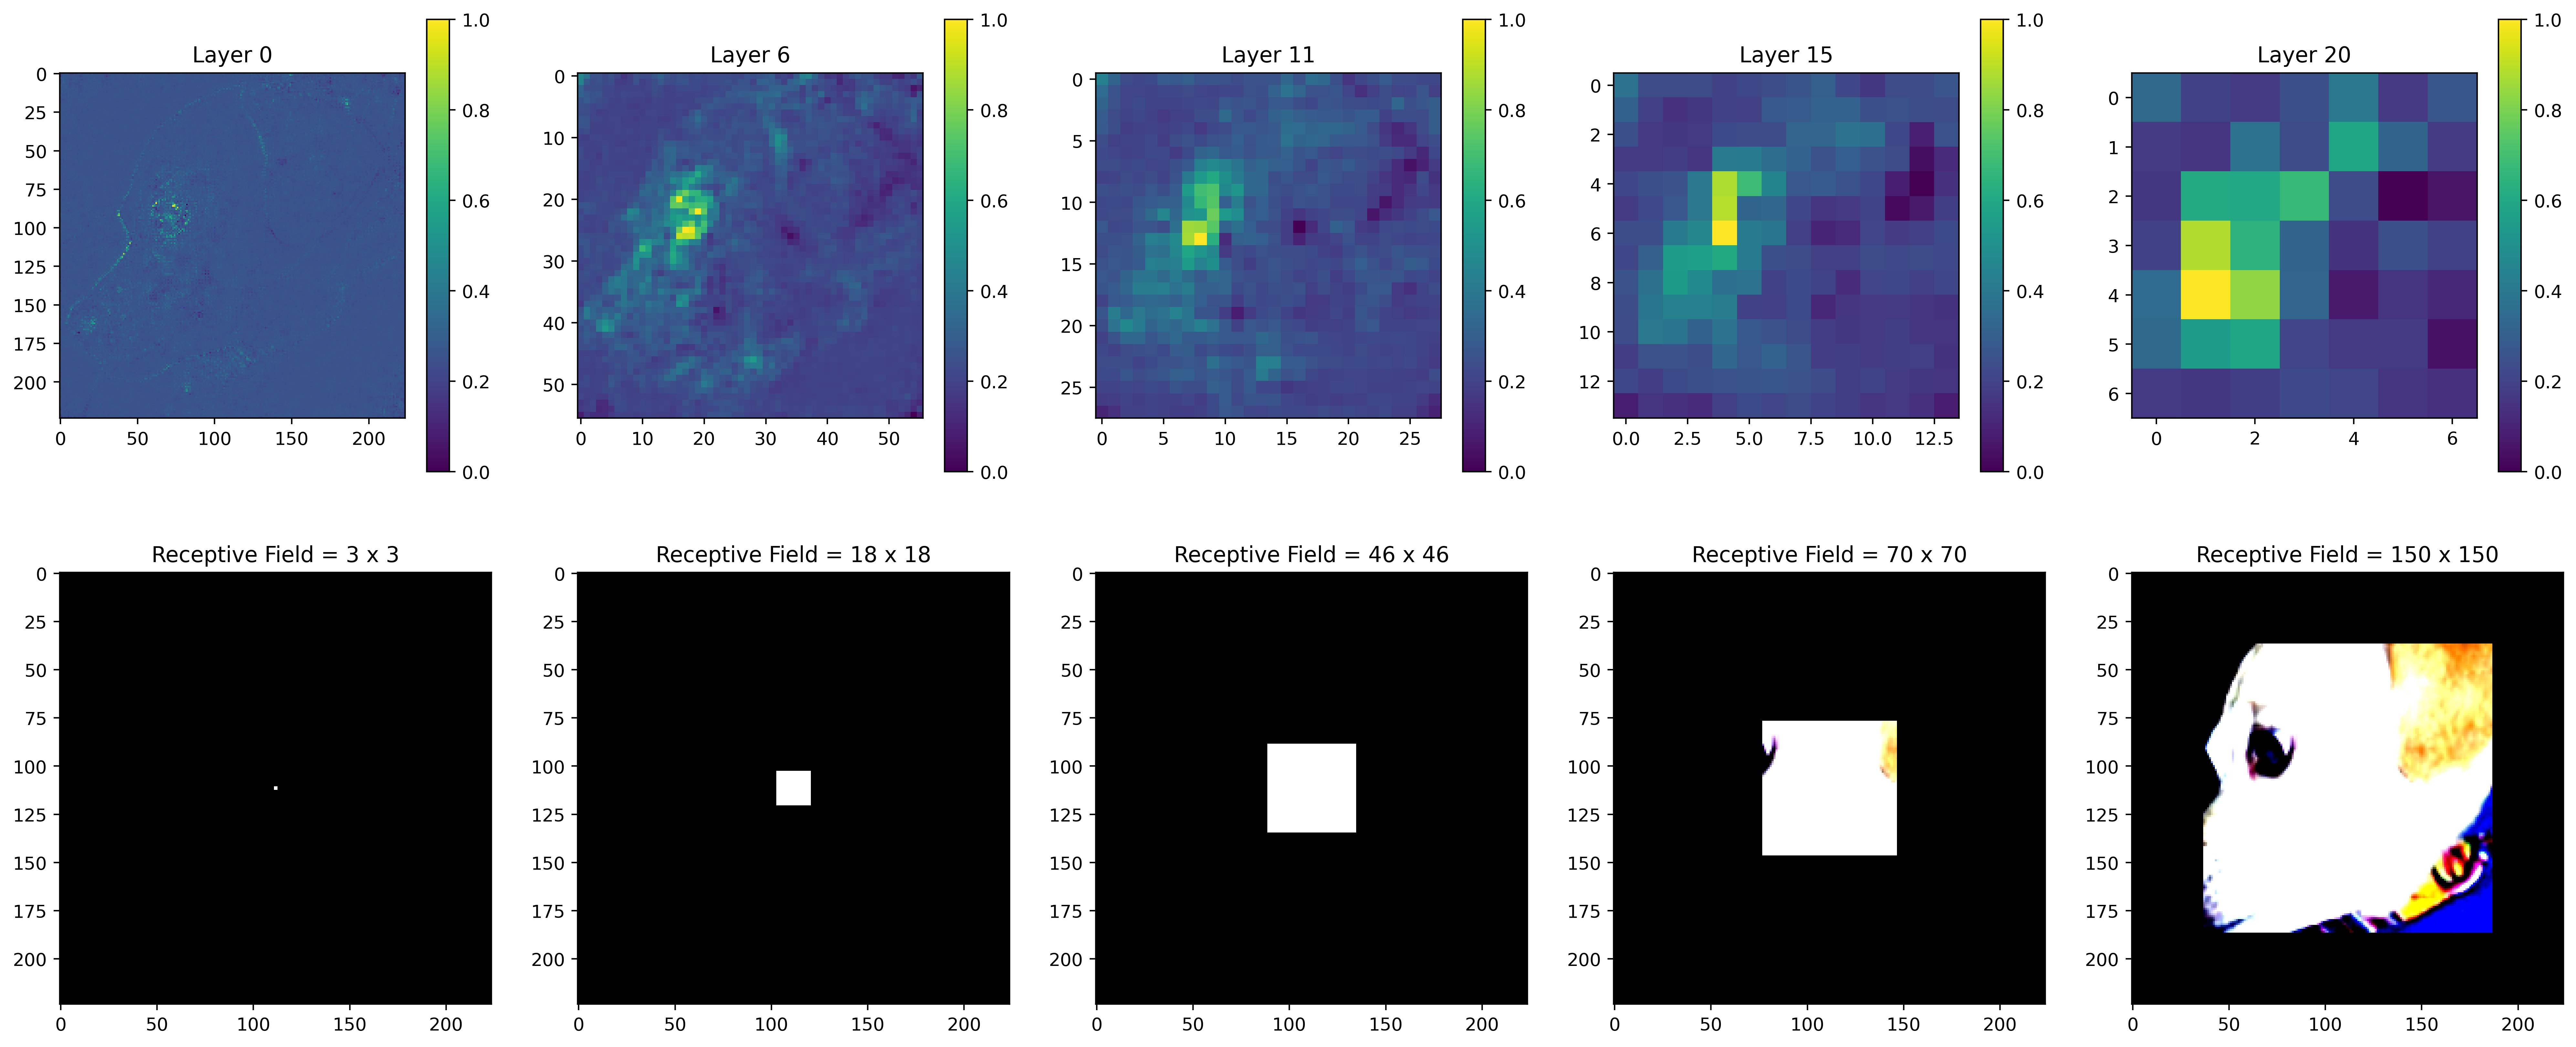

In [ ]:
# Cut the model because the library cannot handle the adaptive pooling layer
receptive_field_dict = receptive_field(cut_model_to_layer(model, "classifier.0", included=False), input_size=(3, 224, 224))

layers_numbers = [0,6,11,15,20]
layers = [model.features[i] for i in layers_numbers]

plt.figure(figsize=(len(layers) * 5, 10), dpi=400)
plt.tight_layout()

input_tensor = test_data[0][0].unsqueeze(0).to(device)
label = test_data[0][1].to(device).reshape(-1)

baseline_dist = torch.cat([images for images, _ in dl_train]).to(device)
for index, layer in enumerate(layers):
    plt.subplot(2, len(layers), index+1)
    attr = _DeepLiftShap()
    attributions = attr.attribute(model=model, input_tensor=input_tensor,layer=layer, target=label, baseline_dist=baseline_dist)
    
    plt.title(f"Layer {layers_numbers[index]}")
    plt.imshow(attributions[0][0].detach().numpy())
    plt.colorbar()

    #================================================================================================

    plt.subplot(2, len(layers), index+1 + len(layers))
    # Plot the receptive field
    rf = receptive_field_dict[str(layers_numbers[index] + 1)]
    rf_size = int(rf["r"])
    # Crop the image at the center with a rf_size x rf_size
    black_background = torch.zeros_like(input_tensor)
    image_center = input_tensor.shape[-1] // 2
    left = image_center - rf_size // 2
    right = image_center + rf_size // 2
    black_background[:,:,left:right,left:right] = input_tensor[:,:,left:right,left:right]
    plt.imshow(black_background.squeeze(0).permute(1,2,0).detach().numpy())
    plt.title(f"Receptive Field = {rf_size} x {rf_size}")  

plt.savefig('receptive_field.pdf', dpi=400, bbox_inches='tight')

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [224, 224]        0.5        1.0             3.0 
        2             [224, 224]        0.5        1.0             3.0 
        3             [112, 112]        1.0        2.0             4.0 
        4             [112, 112]        1.0        2.0             8.0 
        5             [112, 112]        1.0        2.0             8.0 
        6               [56, 56]        2.0        4.0            10.0 
        7               [56, 56]        2.0        4.0            18.0 
        8               [56, 56]        2.0        4.0            18.0 
        9               [56, 56]        2.0        4.0            26.0 
        10              [56, 56]        2.0        4.0            26.0 
        11              [28, 28]        4.0        8.0   

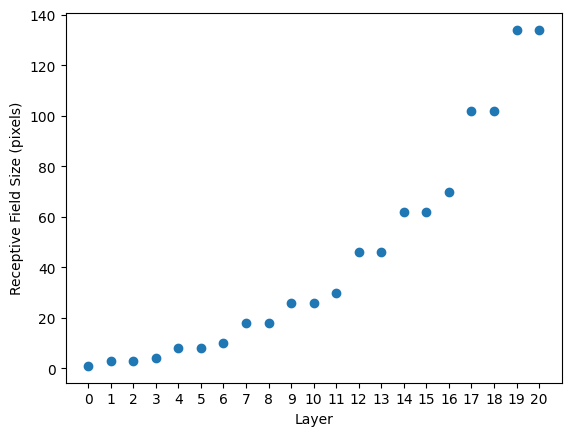

In [8]:
from torch_receptive_field import receptive_field, receptive_field_for_unit

# Cut the model before the adaptive average pooling layer
model1 = cut_model_to_layer(model, "classifier.0", included=False)

d = receptive_field(model1, input_size=(3,224, 224))

plt.plot([d[str(i)]["r"] for i in range(21)], "o")
plt.xlabel("Layer")
plt.ylabel("Receptive Field Size (pixels)")
plt.xticks(range(21))
plt.savefig('receptive_field_size.pdf', dpi=400, bbox_inches='tight')